# <center>Comparison of performance of KNN algorithm and linear regression - case of violent crimes committed in different communities within the United States.</center>

***

<center>Final project for Machine Learning course</center>
<center><b>Ewelina Osowska, Ewa Sobolewska</b></center>

*****

### Table of contents:

* [Dataset description](#dataset-description)
* [Data Preprocessing](#data-preprocessing)
* [Feature selection](#feature-selection)
* [Modelling](#modelling)
    * [Linear regression](#linear-regression)
    * [KNN regression](#knn-regression)
* [Validation and assessment](#validation-and-assessment)
* [Conclusions](#conclusions)

In [1]:
%autosave 0

Autosave disabled


In [151]:
# Loading libraries
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from sklearn import feature_selection
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from astropy.table import Table
import random

# General settings
pd.set_option("display.max_columns",130)
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style="whitegrid")
random.seed(12345)

## Dataset description <a class="anchor" id="dataset-description"></a>

The dataset used in ...

Many variables are included so that algorithms that select or learn weights for attributes could be tested. However, clearly unrelated attributes were not included; attributes were picked if there was any plausible connection to crime (N=122), plus the attribute to be predicted (Per Capita Violent Crimes). The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units. 

The per capita violent crimes variable was calculated using population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was apparently some controversy in some states concerning the counting of rapes. These resulted in missing values for rape, which resulted in incorrect values for per capita violent crime. These cities are not included in the dataset. Many of these omitted communities were from the midwestern USA. 

Data is described below based on original values. All numeric data was normalized into the decimal range 0.00-1.00 using an Unsupervised, equal-interval binning method. Attributes retain their distribution and skew (hence for example the population attribute has a mean value of 0.06 because most communities are small). E.g. An attribute described as 'mean people per household' is actually the normalized (0-1) version of that value. 

The normalization preserves rough ratios of values WITHIN an attribute (e.g. double the value for double the population within the available precision - except for extreme values (all values more than 3 SD above the mean are normalized to 1.00; all values more than 3 SD below the mean are nromalized to 0.00)). 

However, the normalization does not preserve relationships between values BETWEEN attributes (e.g. it would not be meaningful to compare the value for whitePerCap with the value for blackPerCap for a community) 

A limitation was that the LEMAS survey was of the police departments with at least 100 officers, plus a random sample of smaller departments. For our purposes, communities not found in both census and crime datasets were omitted. Many communities are missing LEMAS data. 




The Law Enforcement Management and Administrative Statistics (LEMAS) survey collects data from a nationally representative sample of state, county, and local law enforcement agencies in the United States. For most questions, a reference date of June 30, 2016 was used.

The 2016 LEMAS sample design called for the survey questionnaire to be sent to 3,499 general purpose state and local law enforcement agencies. The design called for all agencies employing 100 or sworn personnel to be included with certainty (self-representing), and for smaller agencies to be sampled from strata based on number of sworn officers and type of agency.

A total of 27 local police departments were determined to be out-of-scope for the survey because they were special jurisdiction agencies, had closed, had outsourced their operations, or were operating on a part-time basis. The final mail out total of 3,472 agencies included 2,613 local police departments, 810 sheriffs' offices, and the 49 state agencies.

A total of 2,780 agencies responded to the LEMAS questionnaire, for a response rate of 80%. The final database includes responses from 2,136 local police departments, 600 sheriffs' offices, and 49 state law enforcement agencies (including partial responses from 5 primary state police agencies). The overall response rate for local police departments was 82%, 74% for sheriffs' offices, and 90% for state law enforcement agencies.

## Data preprocessing <a class="anchor" id="data-preprocessing"></a>

Before each step data is saved in reproducible form of a pickle. The data has 1994 observations and 128 columns. Each observation states for different communities. The steps necessary to get the pickle used below are attached in the supplement.

In [3]:
mydata = pd.read_pickle("dataset/mydata.p")

In [4]:
mydata.shape

(1994, 127)

In [5]:
mydata.head()

,state,county,community,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LemasSwornFT,LemasSwFTPerPop,LemasSwFTFieldOps,LemasSwFTFieldPerPop,LemasTotalReq,LemasTotReqPerPop,PolicReqPerOffic,PolicPerPop,RacialMatchCommPol,PctPolicWhite,PctPolicBlack,PctPolicHisp,PctPolicAsian,PctPolicMinor,OfficAssgnDrugUnits,NumKindsDrugsSeiz,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,0.20,1.0,0.37,0.72,0.34,0.60,0.29,0.15,0.43,0.39,0.40,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.10,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.40,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0.0,0.12,0.42,0.50,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1.0,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.30,0.22,0.35,0.01,0.24,0.14,0.24,0.30,0.27,0.73,0.57,0.15,0.42,0.36,1.00,0.63,0.91,1.00,0.29,0.43,0.47,0.60,0.39,0.46,0.53,0.00,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.10,0.16,0.10,0.17,0.29,0.17,0.26,0.20,0.82,0.0,0.02,0.79,0.24,0.02,0.25,0.65,0.16,0.00,0.21,0.20,0.21,0.42,0.38,0.40,0.37,0.29,0.32,0.18,0.00,0.0,0.21,0.50,0.34,0.60,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,0.00,0.0,0.30,0.58,0.19,0.39,0.38,0.40,0.84,0.28,0.27,0.29,0.27,0.07,0.29,0.28,0.39,0.01,0.27,0.27,0.43,0.19,0.36,0.58,0.32,0.29,0.49,0.32,0.63,0.41,0.71,0.70,0.45,0.42,0.44,0.43,0.43,0.71,0.67,0.01,0.46,0.00,0.07,0.06,0.15,0.19,0.02,0.02,0.04,0.05,0.88,0.04,0.20,0.20,0.46,0.52,0.43,0.42,0.15,0.51,0.5,0.01,0.86,0.41,0.29,0.30,0.52,0.47,0.45,0.18,0.17,0.16,0.27,0.29,0.27,0.31,0.48,0.39,0.28,0.00,0.0,0.14,0.49,0.54,0.67,0.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,0.06,1.0,0.58,0.89,0.21,0.43,0.36,0.20,0.82,0.51,0.36,0.40,0.39,0.16,0.25,0.36,0.44,0.01,0.10,0.09,0.25,0.31,0.33,0.71,0.36,0.45,0.37,0.39,0.34,0.45,0.49,0.44,0.75,0.65,0.54,0.83,0.65,0.85,0.86,0.03,0.33,0.02,0.11,0.20,0.30,0.31,0.05,0.08,0.11,0.11,0.81,0.08,0.56,0.62,0.85,0.77,1.00,0.94,0.12,0.01,0.5,0.

In the dataset there are multiple missing values. They can be divided into three categories. Columns _county_ and _community_ don't have id numbers assigned, however these are only informational values and it doesn't affect the modelling process. Thus these columns may be ommitted without further consequences. The second category are columns that have 1675 missing values. They come from the 1990 LEMAS survey (The Law Enforcement Management and Administrative Statistics) and were not provided originally. Thus the filling of the variables is about 16%, we decided to discard these features from the analysis. The last category is one missing value in _OtherPerCap_ column. There are too few missing values in the column and also there no other important missing values in the row, so we cannot omit it. Taken steps will be explained later on.

In [6]:
print(mydata.isnull().sum()[mydata.isnull().sum()>1])

county                  1174
community               1177
LemasSwornFT            1675
LemasSwFTPerPop         1675
LemasSwFTFieldOps       1675
LemasSwFTFieldPerPop    1675
LemasTotalReq           1675
LemasTotReqPerPop       1675
PolicReqPerOffic        1675
PolicPerPop             1675
RacialMatchCommPol      1675
PctPolicWhite           1675
PctPolicBlack           1675
PctPolicHisp            1675
PctPolicAsian           1675
PctPolicMinor           1675
OfficAssgnDrugUnits     1675
NumKindsDrugsSeiz       1675
PolicAveOTWorked        1675
PolicCars               1675
PolicOperBudg           1675
LemasPctPolicOnPatr     1675
LemasGangUnitDeploy     1675
PolicBudgPerPop         1675
dtype: int64


In [7]:
mydata = mydata.drop(["county", "community"], axis=1)

In [8]:
mydata = mydata.drop(mydata.columns[mydata.apply(lambda col: col.isnull().sum() > 1)], axis=1)

There are many missings inputation methods. As a first step, we checked the distribution of the variable. It seems that its values are aggregated between 0.17 (Q1) and 0.36 (Q3) overall and between 0.15 (Q1) and 0.315 (Q3) only in Mississippi - the state within which the missing value occurs. Thus we decided to fill the value with the median in this state.

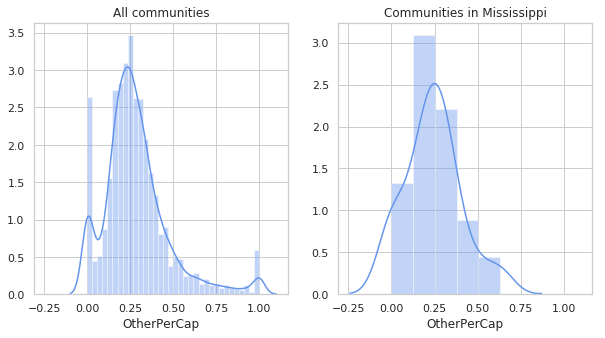

In [9]:
mydata_nonans = mydata.dropna()

f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(mydata_nonans.OtherPerCap, color="cornflowerblue", ax=axes[0]).set_title("All communities")
sns.distplot(mydata_nonans[mydata_nonans.state==28].OtherPerCap, color="cornflowerblue", ax=axes[1]).set_title("Communities in Mississippi")
plt.show()

In [10]:
mydata[mydata.OtherPerCap.isna()]

,state,communityname,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,numbUrban,pctUrban,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,whitePerCap,blackPerCap,indianPerCap,AsianPerCap,OtherPerCap,HispPerCap,NumUnderPov,PctPopUnderPov,PctLess9thGrade,PctNotHSGrad,PctBSorMore,PctUnemployed,PctEmploy,PctEmplManu,PctEmplProfServ,PctOccupManu,PctOccupMgmtProf,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumIlleg,PctIlleg,NumImmig,PctImmigRecent,PctImmigRec5,PctImmigRec8,PctImmigRec10,PctRecentImmig,PctRecImmig5,PctRecImmig8,PctRecImmig10,PctSpeakEnglOnly,PctNotSpeakEnglWell,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,PctHousOccup,PctHousOwnOcc,PctVacantBoarded,PctVacMore6Mos,MedYrHousBuilt,PctHousNoPhone,PctWOFullPlumb,OwnOccLowQuart,OwnOccMedVal,OwnOccHiQuart,RentLowQ,RentMedian,RentHighQ,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
130,28,Natchezcity,0.02,0.38,0.98,0.22,0.01,0.01,0.44,0.4,0.27,0.58,0.0,0.0,0.09,0.24,0.35,0.31,0.65,0.78,0.49,0.12,0.18,0.32,0.15,0.08,0.37,NaN,0.63,0.05,0.85,0.54,0.54,0.29,0.86,0.19,0.31,0.53,0.37,0.51,0.62,0.44,0.62,0.65,0.49,0.2,0.2,0.13,0.19,0.59,0.5,0.04,0.85,0.0,0.22,0.16,0.13,0.11,0.01,0.0,0.0,0.0,0.98,0.02,0.28,0.24,0.4,0.36,0.47,0.52,0.17,0.46,0.5,0.05,0.52,0.55,0.31,0.68,0.38,0.51,0.55,0.06,0.06,0.08,0.0,0.06,0.11,0.11,0.6,0.44,0.76,0.0,0.0,0.01,0.84,0.7,0.83,0.77,0.04,0.12,0.05,0.0,0.23


In [11]:
mydata.OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.17
0.50    0.25
0.75    0.36
Name: OtherPerCap, dtype: float64

In [12]:
mydata[mydata.state==28].OtherPerCap.quantile([0.25, 0.5, 0.75])

0.25    0.1400
0.50    0.2300
0.75    0.3225
Name: OtherPerCap, dtype: float64

In [13]:
mydata.loc[130, "OtherPerCap"] = 0.23

In [14]:
mydata.to_pickle("dataset/mydata_step1.p")

## Feature selection <a class="anchor" id="feature-selection"></a>

Next step of the analysis will be determining which variables to include in the final model. First of all we checked teh variables distributions and its relationship with dependent variable. It occured that some variables obtain few levels of values while being continuous like for example _pctUrban_ and _MedNumBR_. Thus we decided to discretize them. Also many variables seem to have low variance and this lead us to conduct analysis of near zero variance. Plots for all variables can be found in the supplement code.

In [15]:
mydata = pd.read_pickle("dataset/mydata_step1.p")
numCols = ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome','pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire','medFamInc','perCapInc','whitePerCap','blackPerCap','indianPerCap','AsianPerCap','OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad','PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf','MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg','NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10','PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc','PctVacantBoarded', 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal','OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent','MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState','PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LandArea', 'PopDens', 'PctUsePubTrans', 'LemasPctOfficDrugUn']
target_var = 'ViolentCrimesPerPop'

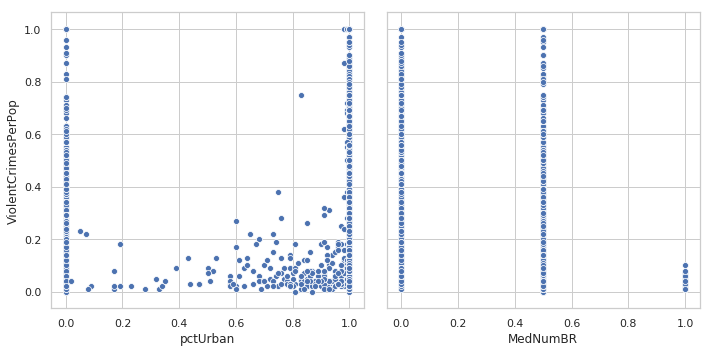

In [16]:
f, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(mydata["pctUrban"], mydata[target_var], ax=axes[0])
sns.scatterplot(mydata["MedNumBR"], mydata[target_var], ax=axes[1])
plt.tight_layout()
plt.show()

As stated before, variables _pctUrban_ and _MedNumBR_ will be discretized. In case of first variable, we will create two bins taking 0.5 as threshold between two levels. In case of second variable, we addidionaly conducted analysis of quantiles in order to decide whether third bin should be considered. It turns out that even in the 98th percentile, the value is still 0.5 so only two bins were created. 

In [17]:
mydata.loc[mydata.pctUrban<0.5, "pctUrban"] = 0
mydata.loc[mydata.pctUrban>=0.5, "pctUrban"] = 1

In [18]:
mydata.MedNumBR.quantile([0.25, 0.5, 0.75, 0.98])

0.25    0.0
0.50    0.5
0.75    0.5
0.98    0.5
Name: MedNumBR, dtype: float64

In [19]:
mydata.loc[mydata.MedNumBR<0.5, "MedNumBR"]=0
mydata.loc[mydata.MedNumBR>=0.5, "MedNumBR"]=1

Because of low variance visible on scatterplots, additional near zero variance was performed. A threshold of 0.02 was set resulting in 8 potentially irrelevant variables. Distributions of these variables are visible below. At this stage we will not omit these variables. Before making decision on dropping those variables, we want to check its correlation with dependent variable and mutual information.

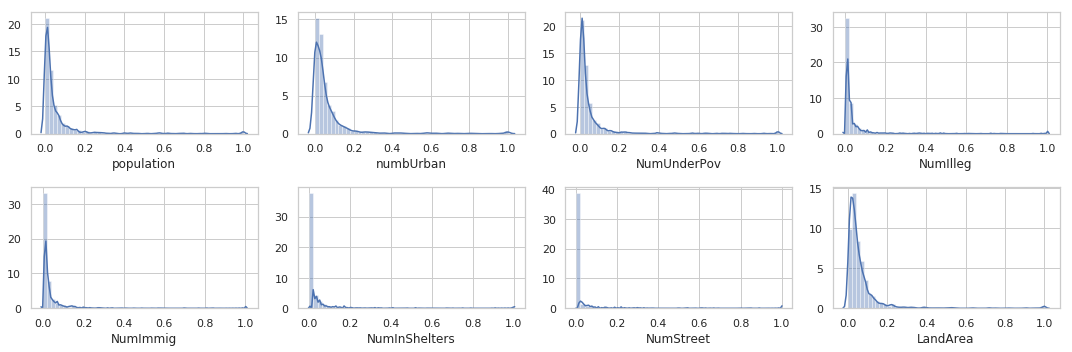

In [20]:
selector = feature_selection.VarianceThreshold(0.02)
selector.fit_transform(mydata[numCols])

f, axes = plt.subplots(2, 4, figsize=(15, 5))
i = 0
nearzerovar = [item for item in np.arange(100) if (item not in selector.get_support(True))]
for col in nearzerovar:
    sns.distplot(mydata[numCols[col]], ax=axes[i//4, i%4])
    i += 1
plt.tight_layout()
plt.show()

Spearman correlation was calculated. Assuming correlation coefficient threshold to be 0.5, 24 variables were returned. The result of correlation was saved into filterdf dataframe.

In [21]:
filterlist = []
for colname in numCols:
    spearman = stats.spearmanr(mydata[colname], mydata[target_var])
    filterlist.append([colname, spearman.correlation, spearman.pvalue])

In [22]:
filterdf = pd.DataFrame(filterlist, columns=('name', 'spearman_coef', 'spearman_pval'))
filterdf.index = filterdf.name
filterdf = filterdf.drop('name', axis=1)

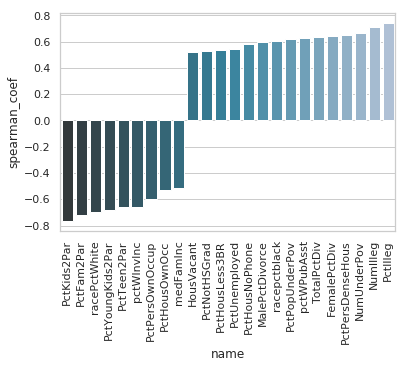

In [23]:
cutoff = 0.5
data = filterdf.spearman_coef[filterdf.spearman_coef.abs()>cutoff].sort_values()
ax = sns.barplot(data.index, y=data, palette="PuBuGn_d")
plt.xticks(rotation=90)
plt.show()

As to mutual information, we used mutual_info_regression function from sklearn library. Higher values indicate higher dependency. The results are saved in midf dataframe.

In [24]:
minfos=[]
for var in numCols:
    minfos.append(feature_selection.mutual_info_regression(mydata[var].astype(float).values.reshape(-1,1), mydata["ViolentCrimesPerPop"].astype(float).values)[0])

In [25]:
midf = list(zip(minfos, numCols))
midf.sort(reverse=True)
midf = pd.DataFrame(midf, columns=['MI', "name"])
midf.index = midf.name
midf = midf.drop("name", axis=1)

Dataframe combining results from correlation and mutual information was saved into allfeaturedf dataframe.

In [26]:
allfeaturedf = filterdf.join(midf)
allfeaturedf.to_pickle("dataset/allfeaturedf.p")

Additional columns were created for 30 best results of Spearman correlation coefficient and Mutual Information.

In [27]:
col = "spearman_coef"
allfeaturedf["spearmanres"] = 0
borderval = allfeaturedf[allfeaturedf.spearman_pval<0.05].abs().sort_values(col, ascending=False).spearman_coef.iloc[30,]
allfeaturedf.loc[(allfeaturedf.spearman_coef<borderval) & (allfeaturedf.spearman_pval<0.05),"spearmanres"] = 1

In [28]:
col = "MI"
allfeaturedf["MIres"] = 0
borderval = allfeaturedf.sort_values(col, ascending=False).MI.iloc[30,]
allfeaturedf.loc[allfeaturedf.MI>borderval,"MIres"] = 1

Below is a list of columns that were chosen as best both by correlatino and MI. They were saced into finalcols.

In [29]:
allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:]

,spearman_coef,spearman_pval,MI,spearmanres,MIres
name,,,,,
racePctWhite,-0.697328,2.011768e-290,0.338591,1,1
racePctHisp,0.324374,4.461401e-50,0.126376,1,1
numbUrban,0.274586,7.981106e-36,0.128122,1,1
medIncome,-0.482170,1.297885e-116,0.157751,1,1
pctWInvInc,-0.658113,8.254017e-248,0.279438,1,1
medFamInc,-0.513162,2.198249e-134,0.202515,1,1
perCapInc,-0.422790,2.766288e-87,0.126356,1,1
blackPerCap,-0.311354,4.469109e-46,0.149899,1,1
PctFam2Par,-0.722948,3.260833e-322,0.376673,1,1


In [30]:
finalcols = allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:].index.tolist()

We conducted a general regression to check performance with variables chosen through correlation and MI. As a result we obtained a model with Adjusted R2 63.3% and RMSE 2.22. AIC turned out pretty low at -2133. However, we cannot assess if this model is good or bad since we don't have a benchmark.

In [115]:
y = mydata[target_var]
X = mydata[finalcols]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

2.215639583179178

In [116]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.633
Method:                  Least Squares   F-statistic:                     246.2
Date:                 Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                         21:07:58   Log-Likelihood:                 1081.6
No. Observations:                 1994   AIC:                            -2133.
Df Residuals:                     1979   BIC:                            -2049.
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6919      0.024     28.689      0.000       0.645       0.739
racePctWhite        -0.2098      0.025     -8.525      0.000      -0.258      -0.162
racePctHisp          0.0544      0.019      2.883      0.004       0.017       0.091
numbUrban            0.2497      0.027      9.143      0.000       0.196       0.303
medIncome            0.0928      0.097      0.955      0.340      -0.098       0.283
pctWInvInc          -0.2069      0.045     -4.632      0.000      -0.295      -0.119
medFamInc           -0.0892      0.105     -0.852      0.394      -0.294       0.116
perCapInc            0.9082      0.170      5.348      0.000       0.575       1.241
blackPerCap         -0.1378      0.062     -2.231      0.026      -0.259      -0.017
PctFam2Par          -0.0383      0.135     -0.285      0.776      -0.302       0.226
PctKids2Par         -0.5059      0.129     -3.920      0.000      -0.759      -0.253
PctYoungKids2Par    -0.0655      0.045     -1.463      0.143      -0.153       0.022
PctTeen2Par          0.0041      0.043      0.095      0.925      -0.080       0.088
PctPersOwnOccup     -0.2777      0.112     -2.485      0.013      -0.497      -0.059
PctHousOwnOcc        0.3059      0.114      2.686      0.007       0.083       0.529
==============================================================================
Omnibus:                      388.266   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1091.607
Skew:                           1.011   Prob(JB):                    9.13e-238
Kurtosis:                       6.008   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our first idea of improvement of model is through a logarithmic transformation of the target variable. Graphical analysis doesn't show much of a difference but the results of linear regression seem to have improved. Adjusted R2 has increased by 2.5p.p. and AIC has decreased by about 1400. RMSE is also lower by 0.57.

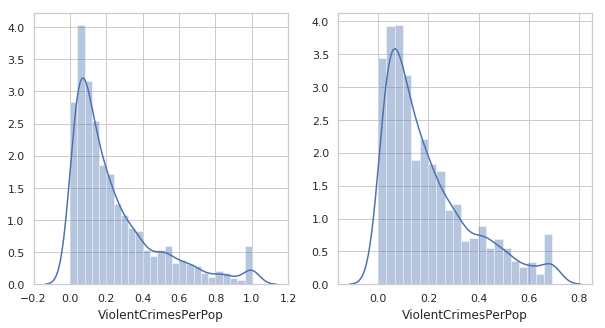

In [155]:
f, axes = plt.subplots(1,2, figsize=(10,5))
sns.distplot(mydata[target_var], ax=axes[0])
sns.distplot(np.log(mydata[target_var]+1), ax=axes[1])

In [119]:
y = np.log(mydata[target_var]+1)
X = mydata[finalcols]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.6478623761331685

In [120]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.660
Model:                             OLS   Adj. R-squared:                  0.658
Method:                  Least Squares   F-statistic:                     275.0
Date:                 Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                         21:08:12   Log-Likelihood:                 1782.0
No. Observations:                 1994   AIC:                            -3534.
Df Residuals:                     1979   BIC:                            -3450.
Df Model:                           14                                         
Covariance Type:             nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5139      0.017     30.280      0.000       0.481       0.547
racePctWhite        -0.1442      0.017     -8.326      0.000      -0.178      -0.110
racePctHisp          0.0504      0.013      3.792      0.000       0.024       0.076
numbUrban            0.1762      0.019      9.163      0.000       0.138       0.214
medIncome           -0.0049      0.068     -0.072      0.943      -0.139       0.129
pctWInvInc          -0.1900      0.031     -6.042      0.000      -0.252      -0.128
medFamInc           -0.0239      0.074     -0.324      0.746      -0.168       0.121
perCapInc            0.8166      0.120      6.832      0.000       0.582       1.051
blackPerCap         -0.0973      0.043     -2.238      0.025      -0.183      -0.012
PctFam2Par          -0.0054      0.095     -0.057      0.955      -0.191       0.180
PctKids2Par         -0.3902      0.091     -4.296      0.000      -0.568      -0.212
PctYoungKids2Par    -0.0443      0.031     -1.408      0.159      -0.106       0.017
PctTeen2Par          0.0151      0.030      0.500      0.617      -0.044       0.074
PctPersOwnOccup     -0.2766      0.079     -3.516      0.000      -0.431      -0.122
PctHousOwnOcc        0.2940      0.080      3.668      0.000       0.137       0.451
==============================================================================
Omnibus:                      268.060   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              577.174
Skew:                           0.797   Prob(JB):                    4.66e-126
Kurtosis:                       5.099   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We decided to take also another, automated approach which is forward selection. We based our implementation on a function  which can be found in this link https://planspace.org/20150423-forward_selection_with_statsmodels/.

In [127]:
def forward_selected(data, response):
    y = np.log(mydata[response]+1)
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining:
        scores_with_candidates = []
        for candidate in remaining:
            X = mydata[selected + [candidate]]
            X = sm.add_constant(X)
            score = sm.OLS(y, X).fit().pvalues[candidate]
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if 0.05 > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        if 0.05<best_new_score:
            break
    X = mydata[selected + [candidate]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("The optimal model consists of {} variables.".format(len(selected)))
    class myresult:
        pass
    myresult.model = model
    myresult.selected=selected
    return myresult

The result of function are selected 22 variables and saved in fs object. Their names and coefficients can be seen below.

In [128]:
mydataols = mydata[numCols]
fs = forward_selected(mydataols, target_var)

The optimal model consists of 22 variables.


In [129]:
fs.model.params

const                    0.341017
PctIlleg                 0.121086
FemalePctDiv            -0.058326
racePctWhite            -0.079494
HousVacant               0.186658
PctKids2Par             -0.258419
PctWorkMom              -0.035964
pctUrban                 0.026972
PctPersDenseHous         0.120085
MalePctDivorce           0.128729
racepctblack             0.077411
NumStreet                0.113861
NumUnderPov             -0.128070
MedOwnCostPctIncNoMtg   -0.058031
agePct12t29             -0.040949
OtherPerCap              0.035343
pctWInvInc              -0.141496
perCapInc                1.110832
MedRentPctHousInc        0.043892
RentLowQ                -0.164658
MedRent                  0.139594
blackPerCap             -0.110834
whitePerCap             -0.673170
PctTeen2Par              0.004317
dtype: float64

In order to compare results we decided to compare which columns were identified through the filter method, which by forward selection and which by both.

In [164]:
finalcols_MIcorr = set(finalcols)

finalcols_fs = set(fs.selected)

print("""Columns found by filter not by forward selection: {} \n
Columns found by forward selection not by filter: {} \n
Columns found by both: {}""".format(", ".join(list(finalcols_MIcorr-finalcols_fs)),
                                            ", ".join(list(finalcols_fs-finalcols_MIcorr)),
                                            ", ".join(list(finalcols_MIcorr&finalcols_fs))))

Columns found by filter not by forward selection: PctTeen2Par, racePctHisp, numbUrban, PctPersOwnOccup, PctFam2Par, medFamInc, PctHousOwnOcc, PctYoungKids2Par, medIncome 

Columns found by forward selection not by filter: whitePerCap, PctWorkMom, MedRent, OtherPerCap, FemalePctDiv, MedOwnCostPctIncNoMtg, RentLowQ, MedRentPctHousInc, MalePctDivorce, NumUnderPov, agePct12t29, pctUrban, PctIlleg, racepctblack, NumStreet, PctPersDenseHous, HousVacant 

Columns found by both: PctKids2Par, perCapInc, blackPerCap, racePctWhite, pctWInvInc


The next regression that we decided to perform was on the 22 variables that were identified by the forward selection algorithm. We can observe that RMSE decreased by 0.3, Adjusted R2 improved by 3 p.p. and AIC decreased by 200. 
# ????????????????

In [133]:
y = np.log(mydata[target_var]+1)
X = mydata[list(finalcols_fs)]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.3445976079829431

In [134]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.691
Model:                             OLS   Adj. R-squared:                  0.688
Method:                  Least Squares   F-statistic:                     200.4
Date:                 Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                         21:17:01   Log-Likelihood:                 1876.0
No. Observations:                 1994   AIC:                            -3706.
Df Residuals:                     1971   BIC:                            -3577.
Df Model:                           22                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3426      0.053      6.464      0.000       0.239       0.446
whitePerCap              -0.6756      0.289     -2.336      0.020      -1.243      -0.108
agePct12t29              -0.0414      0.019     -2.171      0.030      -0.079      -0.004
racepctblack              0.0773      0.027      2.862      0.004       0.024       0.130
PctKids2Par              -0.2549      0.037     -6.951      0.000      -0.327      -0.183
MedRent                   0.1399      0.039      3.542      0.000       0.062       0.217
RentLowQ                 -0.1649      0.037     -4.451      0.000      -0.238      -0.092
MedRentPctHousInc         0.0438      0.017      2.648      0.008       0.011       0.076
MalePctDivorce            0.1292      0.035      3.676      0.000       0.060       0.198
NumUnderPov              -0.1280      0.042     -3.074      0.002      -0.210      -0.046
pctUrban                  0.0269      0.006      4.839      0.000       0.016       0.038
PctIlleg                  0.1209      0.027      4.541      0.000       0.069       0.173
HousVacant                0.1865      0.033      5.672      0.000       0.122       0.251
PctWorkMom               -0.0360      0.009     -4.045      0.000      -0.053      -0.019
OtherPerCap               0.0354      0.013      2.827      0.005       0.011       0.060
FemalePctDiv             -0.0593      0.038     -1.565      0.118      -0.134       0.015
MedOwnCostPctIncNoMtg    -0.0581      0.013     -4.479      0.000      -0.084      -0.033
racePctWhite             -0.0798      0.033     -2.396      0.017      -0.145      -0.014
NumStreet                 0.1139      0.028      4.009      0.000       0.058       0.170
PctPersDenseHous          0.1203      0.025      4.889      0.000       0.072       0.169
perCapInc                 1.1132      0.323      3.449      0.001       0.480       1.746
blackPerCap              -0.1112      0.042     -2.630      0.009      -0.194      -0.028
pctWInvInc               -0.1421      0.034     -4.224      0.000      -0.208      -0.076
==============================================================================
Omnibus:                      290.858   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              724.047
Skew:                           0.808   Prob(JB):                    5.96e-158
Kurtosis:                       5.471   Cond. No.                         446.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# BOXCOX

In [142]:
mydata_boxcox = mydata

In [143]:
# http://dataunderthehood.com/2018/01/15/box-cox-transformation-with-python/
def normtesttab(x):
    nm_value, nm_p = stats.normaltest(x)
    jb_value, jb_p = stats.jarque_bera(x)
    data_rows = [('D’Agostino-Pearson', nm_value, nm_p),
                 ('Jarque-Bera', jb_value, jb_p)]
    t = Table(rows=data_rows, names=('Test name', 'Statistic', 'p-value'), 
              meta={'name': 'normal test table'},
          dtype=('S25', 'f8', 'f8'))
    return nm_p, jb_p, t

In [144]:
for col in finalcols_fs|finalcols_MIcorr:
    xt, maxlog, interval = stats.boxcox(mydata[col]+1, alpha=0.05)
    if ((normtesttab(mydata[col]+1)[0]>0.05)and(normtesttab(mydata[col]+1)[1]>0.05)):
        pass
    if ((normtesttab(xt)[0]>=0.05)and(normtesttab(xt)[1]>=0.05)):
        if ((normtesttab(mydata[col]+1)[0]<0.05) and (normtesttab(mydata[col]+1)[1]<0.05)):
            mydata_boxcox[col] = xt

In [147]:
y = np.log(mydata_boxcox[target_var]+1)
X = mydata_boxcox[list(finalcols_fs2)]
X = sm.add_constant(X)
np.sqrt(sm.OLS(y, X).fit().mse_model)

1.3758571914082576

In [148]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.691
Model:                             OLS   Adj. R-squared:                  0.687
Method:                  Least Squares   F-statistic:                     209.6
Date:                 Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                         21:20:32   Log-Likelihood:                 1874.8
No. Observations:                 1994   AIC:                            -3706.
Df Residuals:                     1972   BIC:                            -3582.
Df Model:                           21                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3223      0.051      6.270      0.000       0.221       0.423
whitePerCap              -0.6867      0.289     -2.374      0.018      -1.254      -0.120
agePct12t29              -0.0430      0.019     -2.261      0.024      -0.080      -0.006
racepctblack              0.0798      0.027      2.960      0.003       0.027       0.133
PctKids2Par              -0.2422      0.036     -6.770      0.000      -0.312      -0.172
MedRent                   0.1467      0.039      3.738      0.000       0.070       0.224
RentLowQ                 -0.1707      0.037     -4.631      0.000      -0.243      -0.098
MedRentPctHousInc         0.0426      0.017      2.574      0.010       0.010       0.075
MalePctDivorce            0.0880      0.023      3.777      0.000       0.042       0.134
NumUnderPov              -0.1329      0.042     -3.200      0.001      -0.214      -0.051
pctUrban                  0.0265      0.006      4.768      0.000       0.016       0.037
PctIlleg                  0.1268      0.026      4.810      0.000       0.075       0.179
HousVacant                0.1908      0.033      5.819      0.000       0.126       0.255
PctWorkMom               -0.0365      0.009     -4.111      0.000      -0.054      -0.019
OtherPerCap               0.0351      0.013      2.805      0.005       0.011       0.060
MedOwnCostPctIncNoMtg    -0.0544      0.013     -4.263      0.000      -0.079      -0.029
racePctWhite             -0.0767      0.033     -2.307      0.021      -0.142      -0.011
NumStreet                 0.1148      0.028      4.039      0.000       0.059       0.171
PctPersDenseHous          0.1191      0.025      4.842      0.000       0.071       0.167
perCapInc                 1.0810      0.322      3.355      0.001       0.449       1.713
blackPerCap              -0.1139      0.042     -2.695      0.007      -0.197      -0.031
pctWInvInc               -0.1271      0.032     -3.940      0.000      -0.190      -0.064
==============================================================================
Omnibus:                      291.667   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.475
Skew:                           0.812   Prob(JB):                    1.31e-157
Kurtosis:                       5.462   Cond. No.                         435.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Box cox zostawiamy, ale nam niepotrzebny, jest ok bez niego

ostateczny model:

zlogarytmowana zmienna
finalcols_fs2 lub finalcols_MIcorr, bez usuwania zmiennych bo nie możemy patrzeć na pvalue
bez Boxacoxa, bez logarytmowania innych zmiennych

ewentualnie feature selection na podstawie R2 - niżej ale wychodzi bardzo dużo zmiennych

### a co jak forward selection na podstawie R2 adj?

In [51]:
# https://planspace.org/20150423-forward_selection_with_statsmodels/ but a bit edited to our needs
def forward_selected_R2(data, response, plot=True):
    y = mydata[response]
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    score_history = []
    current_score, best_new_score = 0.0, 0.0
    score_history.append(current_score)
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            X = mydata[selected + [candidate]]
            X = sm.add_constant(X)
            score = sm.OLS(y, X).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            score_history.append(current_score)
    X = mydata[selected + [candidate]]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print("The optimal model consists of {} variables.".format(len(selected)))
    if plot:
        plt.figure(figsize=(15,5))
        sns.lineplot(x = np.arange(len(selected)+1), y = score_history)
        plt.title("Adjusted R2 result while adding subsequent variables")
        plt.show()
    return model, selected, score_history

The optimal model consists of 61 variables.


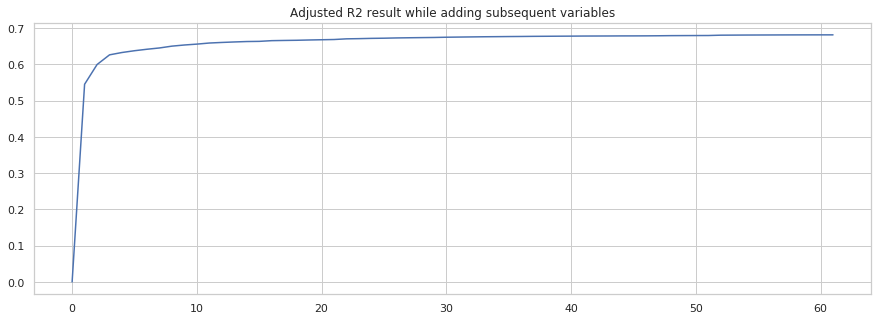

In [54]:
result = forward_selected_R2(mydataols, target_var)

In [56]:
np.sqrt(result[0].mse_model)

1.0980736942599083

In [55]:
result[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ViolentCrimesPerPop   R-squared:                       0.691
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     69.66
Date:                 Mon, 06 May 2019   Prob (F-statistic):               0.00
Time:                         20:41:01   Log-Likelihood:                 1246.9
No. Observations:                 1994   AIC:                            -2368.
Df Residuals:                     1931   BIC:                            -2015.
Df Model:                           62                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.6047      0.161      3.754      0.000       0.289       0.921
PctKids2Par              -0.3082      0.085     -3.640      0.000      -0.474      -0.142
racePctWhite             -0.0702      0.054     -1.305      0.192      -0.176       0.035
HousVacant                0.1489      0.069      2.150      0.032       0.013       0.285
pctUrban                  0.0367      0.010      3.862      0.000       0.018       0.055
PctWorkMom               -0.1057      0.032     -3.326      0.001      -0.168      -0.043
NumStreet                 0.1854      0.046      4.006      0.000       0.095       0.276
MalePctDivorce            0.3331      0.095      3.511      0.000       0.147       0.519
PctIlleg                  0.1440      0.044      3.245      0.001       0.057       0.231
numbUrban                -0.0831      0.111     -0.752      0.452      -0.300       0.134
PctPersDenseHous          0.1863      0.069      2.685      0.007       0.050       0.322
racepctblack              0.1738      0.045      3.845      0.000       0.085       0.262
agePct12t29              -0.3232      0.098     -3.293      0.001      -0.516      -0.131
MedOwnCostPctIncNoMtg    -0.0843      0.023     -3.671      0.000      -0.129      -0.039
OtherPerCap               0.0460      0.018      2.499      0.013       0.010       0.082
MalePctNevMarr            0.2138      0.057      3.761      0.000       0.102       0.325
pctWInvInc               -0.2140      0.062     -3.448      0.001      -0.336      -0.092
LemasPctOfficDrugUn       0.0268      0.015      1.763      0.078      -0.003       0.057
PctPopUnderPov           -0.1651      0.060     -2.767      0.006      -0.282      -0.048
pctWFarmSelf              0.0464      0.019      2.409      0.016       0.009       0.084
MedRentPctHousInc         0.0555      0.030      1.866      0.062      -0.003       0.114
RentLowQ                 -0.2429      0.056     -4.330      0.000      -0.353      -0.133
MedRent                   0.3645      0.097      3.774      0.000       0.175       0.554
pctWRetire               -0.1320      0.057     -2.328      0.020      -0.243      -0.021
pctWWage                 -0.1877      0.077     -2.441      0.015      -0.338      -0.037
TotalPctDiv              -0.2841      0.103     -2.750      0.006      -0.487      -0.081
PctEmploy                 0.1459      0.045      3.241      0.001       0.058       0.234
PctLess9thGrade          -0.0643      0.037     -1.721      0.085      -0.138       0.009
OwnOccLowQuart           -0.0833      0.046     -1.824      0.068      -0.173       0.006
PctVacMore6Mos           -0.0750      0.024     -3.172      0.002      -0.121      -0.029
PctVacantBoarded          0.0529      0.021      2.569      0.010       0.013       0.093
PctLargHouse

### dla tych 30 co zostaly zobaczyc ktore sa jakie wg plota ponizej

In [ ]:
def plot_eval(methods, dataframe, response):
    y = mydata[response]
    if type(methods)==str:
        methods = [methods]
    results = {}
    for method in methods:
        dataframe.sort_values(method)
        result_temp = []
        selected = []
        for column in dataframe.head(25).index:
            selected = selected + [column]
            X = mydata[selected]
            X = sm.add_constant(X)
            scoreR2 = sm.OLS(y, X).fit().rsquared_adj
            scoreMSE = sm.OLS(y,X).fit().mse_model
            scoreAIC = sm.OLS(y,X).fit().aic
            scoreBIC = sm.OLS(y,X).fit().bic
            result_temp.append([scoreR2, scoreMSE, scoreAIC, scoreBIC])
        results[method]=pd.DataFrame(result_temp, columns=["R2", "MSE", "AIC", "BIC"])
    return results

In [ ]:
for col in res['MI'].columns:
    sns.lineplot(res['MI'].index, res['MI'][col], palette="Blues")
    plt.show()

In [ ]:
x1=x.reshape(500)
x1=(x1 - x1.mean()) / (x1.max() - x1.min())
xt1=xt.reshape(500)
xt1=(xt1 - xt1.mean()) / (xt1.max() - xt1.min())
sns.kdeplot(x1, shade=True, label="Raw (normalized)" );
sns.kdeplot(xt1, shade=True, label="Transformed (normalized)" );

### corrplot

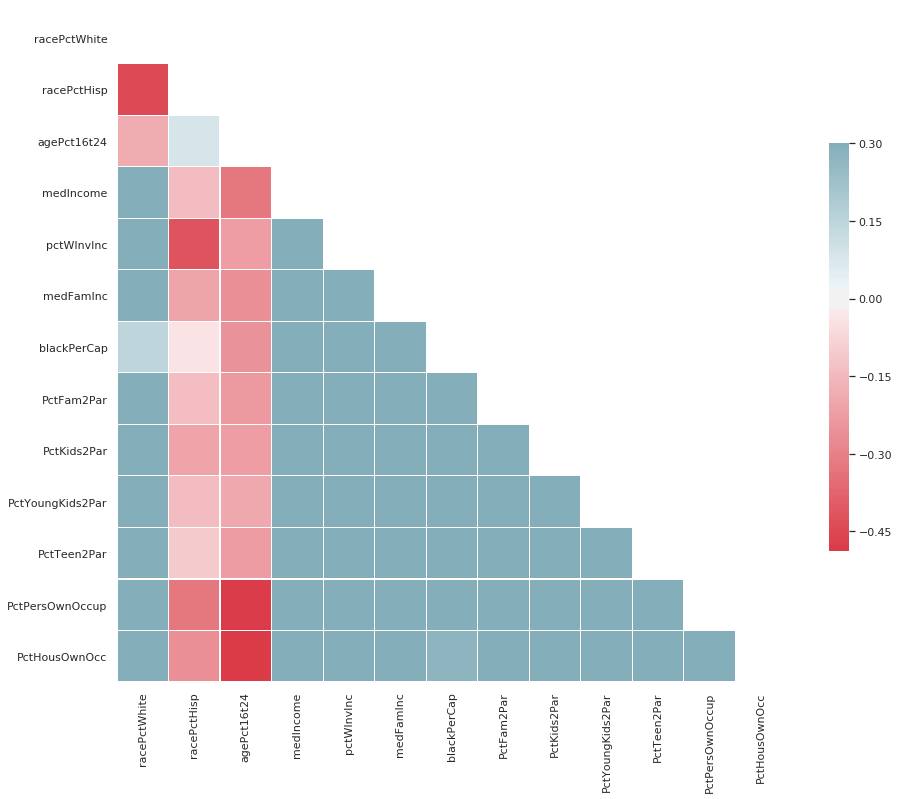

In [72]:
mydata_new = mydata[allfeaturedf.loc[(allfeaturedf.spearmanres==1) & (allfeaturedf.MIres==1),:].index.tolist()]
corr = mydata_new.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
# sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.2, cbar_kws={"shrink": .5})

# KNN

## Modelling <a class="anchor" id="modelling"></a>

### Linear regression <a class="anchor" id="linear-regression"></a>

### KNN regression <a class="anchor" id="knn-regression"></a>

## Validation and assessment <a class="anchor" id="validation-and-assessment"></a>

## Conclusions <a class="anchor" id="conclusions"></a>

The main difference between KNN and linear regression is that Linear regression is a parametric method, which means that it assumes a given mathematical form of model but KNN doesn't being a non-parametric model. Parametric models, while simplifying the relationship of data are easier to interpret. They also tend to work better on small datasets.